# Real-World Datasets

This notebook consists in studying the properties of the usual datasets used in time series forecasting. It is paired with the first notebook "Synthetic Datasets".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import spectrogram

The datasets may differ in the frequency domain. For example, some usual datasets (for example traffic, electricity, ETT's) show very regular patterns, which is translated by regular frequencies in their spectrogram, while some others (like exchange) are very subject to stochasticity and provide different frequency profiles. In order to calibrate the frequency-based metrics properly, it is of relevance to do a preliminary study of the datasets.

In [2]:
def plot_series(series, start_index=100, num_samples=192, dataset='traffic', channel='5'):

    end_index = start_index + num_samples
    plt.figure(figsize=(10, 6))
    plt.plot(series[start_index:end_index])
    plt.title(f"Time Series ({num_samples} samples from time step {start_index}) (datastet: {dataset}, channel: {channel})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

def plot_spectrogram(series, N_w, N_o, sampling_rate=1, dataset='traffic', channel='5'):
    f, t, Sxx = spectrogram(series, fs=sampling_rate, window='hann', nperseg=N_w, noverlap=N_o, detrend=False, scaling='density', mode='psd')
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Intensity [dB]')
    plt.title(f'Spectrogram of the signal (datastet: {dataset}, channel: {channel})')
    plt.ylabel('Frequency (x3600) [Hz]')
    plt.xlabel('Time [hour]')
    plt.show()

def plot_normalized_absolute_Fourier_coefs(series, sampling_rate=1, dataset='traffic', channel='5', start_index=100, num_samples=192):

    series = series[start_index:start_index+num_samples]
    N = len(series)
    yf = rfft(series)
    xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
    coefs = (2.0/N) * np.abs(yf[:N//2])
    coefs_norm = coefs / np.sum(coefs)

    plt.figure(figsize=(10, 6))
    plt.plot(xf, coefs_norm)
    plt.title(f"Normalized absolute Fourier coefficients of the signal (datastet: {dataset}, channel: {channel})")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("Relative amplitude")
    plt.grid()
    plt.show()

def plot_normalized_PSD(series, sampling_rate=1, dataset='traffic', channel='5', start_index=100, num_samples=192):

    series = series[start_index:start_index+num_samples]
    N = len(series)
    yf = rfft(series)
    xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
    power = (2.0/N) * np.abs(yf[:N//2])**2
    power_norm = power / np.sum(power)

    plt.figure(figsize=(10, 6))
    plt.plot(xf, power_norm)
    plt.title(f"Power Spectral Density of the whole signal (datastet: {dataset}, channel: {channel})")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("PSD")
    plt.grid()
    plt.show()

def plot_average_normalized_absolute_Fourier_coefs(series, sampling_rate=1, dataset='traffic', channel='5', N_w=192, N_o=144):

    step_size = N_w - N_o
    num_segments = (len(series) - N_o) // step_size
    accumulated_coefs = None

    for i in range(num_segments):
        start_idx = i * step_size
        end_idx = start_idx + N_w
        segment = series[start_idx:end_idx]
        
        N = len(segment)
        yf = rfft(segment)
        xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
        absolute_coefs = (2.0 / N) * np.abs(yf[:N//2])
        
        if accumulated_coefs is None:
            accumulated_coefs = absolute_coefs
        else:
            accumulated_coefs += absolute_coefs

    average_absolute_coefs = accumulated_coefs / num_segments
    normalized_absolute_coefs = average_absolute_coefs / np.sum(average_absolute_coefs)

    plt.figure(figsize=(10, 6))
    plt.plot(xf, normalized_absolute_coefs)
    plt.title(f"Average normalized absolute Fourier coefficients of the signal (datastet: {dataset}, channel: {channel})")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("Relative amplitude")
    plt.grid()
    plt.show()

def plot_average_normalized_PSD(series, sampling_rate=1, dataset='traffic', channel='5', N_w=192, N_o=144):

    step_size = N_w - N_o
    num_segments = (len(series) - N_o) // step_size
    accumulated_squared_coefs = None

    for i in range(num_segments):
        start_idx = i * step_size
        end_idx = start_idx + N_w
        segment = series[start_idx:end_idx]
        
        N = len(segment)
        yf = rfft(segment)
        xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
        squared_coefs = (2.0 / N) * np.abs(yf[:N//2])**2
        
        if accumulated_squared_coefs is None:
            accumulated_squared_coefs = squared_coefs
        else:
            accumulated_squared_coefs += squared_coefs

    average_squared_coefs = accumulated_squared_coefs / num_segments
    normalized_average_squared_coefs = average_squared_coefs / np.sum(average_squared_coefs)

    plt.figure(figsize=(10, 6))
    plt.plot(xf, normalized_average_squared_coefs)
    plt.title(f"Average Power Spectral Density of the signal (datastet: {dataset}, channel: {channel})")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("PSD")
    plt.grid()
    plt.show()

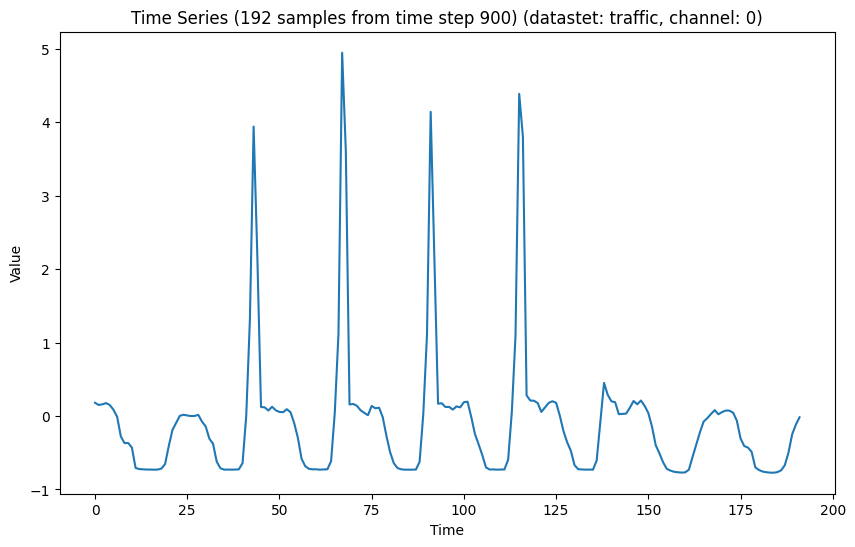

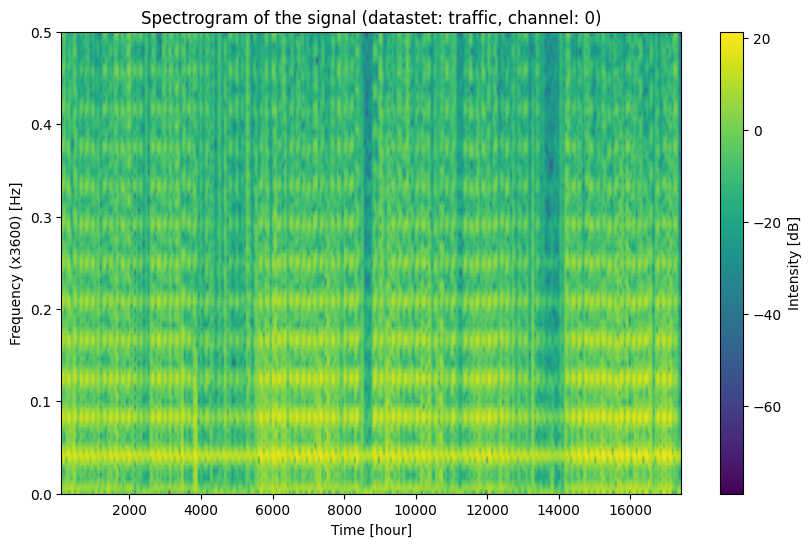

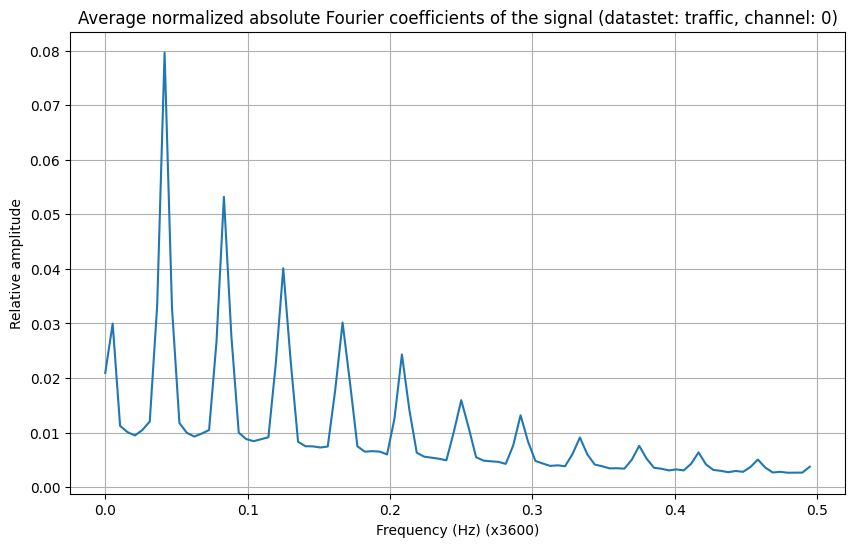

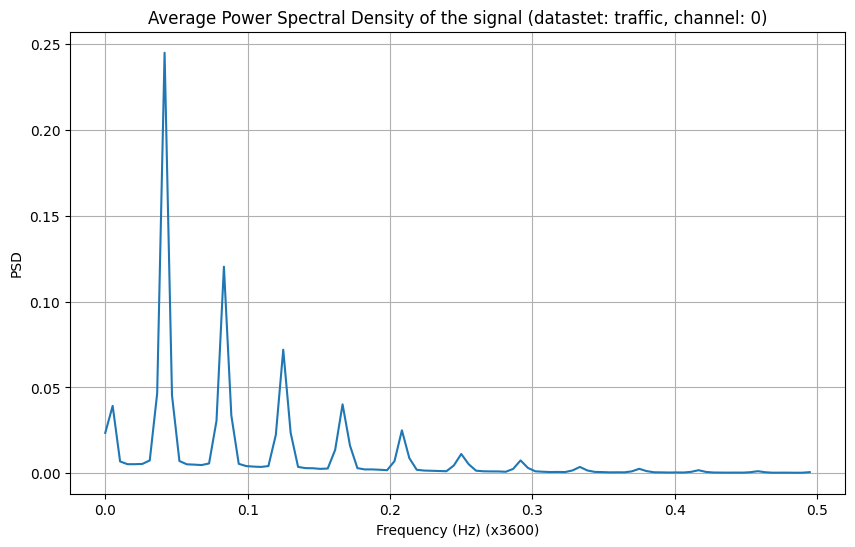

In [6]:
df = pd.read_csv("./dataset/traffic/traffic.csv")
series = df['0']
series = (series - np.mean(series)) / np.std(series)
series = series.to_numpy()
plot_series(series, start_index=900, num_samples=192, dataset='traffic', channel='0')
plot_spectrogram(series, N_w=192, N_o=144, dataset='traffic', channel='0')
plot_average_normalized_absolute_Fourier_coefs(series, dataset='traffic', channel='0')
plot_average_normalized_PSD(series, dataset='traffic', channel='0')

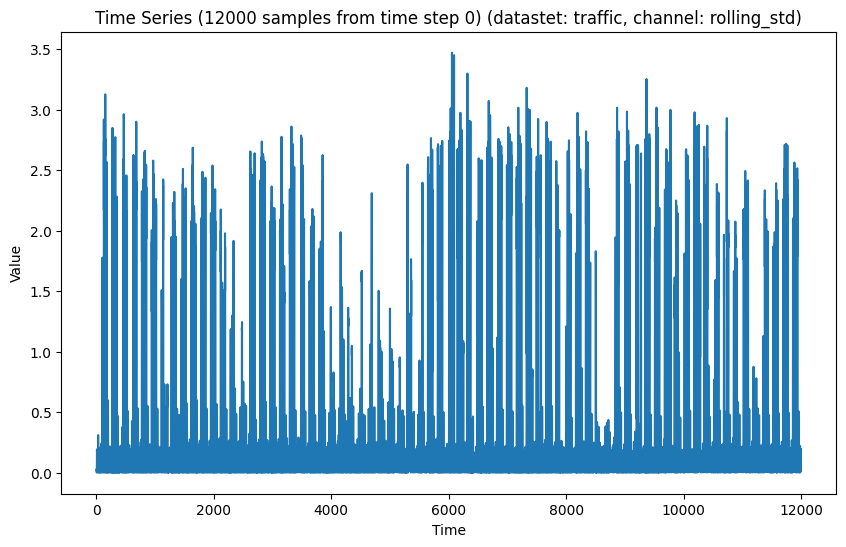

In [5]:
df = pd.read_csv("./dataset/traffic/traffic.csv")
series = df["0"]
series = (series - np.mean(series)) / np.std(series)
rolling_std = series.rolling(window=3).std()
std_of_rolling_std = np.std(rolling_std.dropna())
series = series.to_numpy()
plot_series(rolling_std.to_numpy(), start_index=0, num_samples=12000, dataset='traffic', channel='rolling_std')

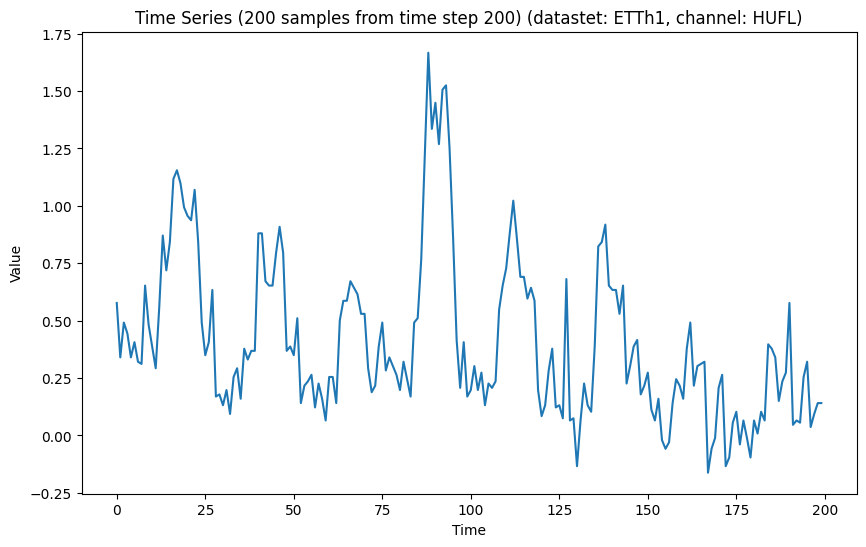

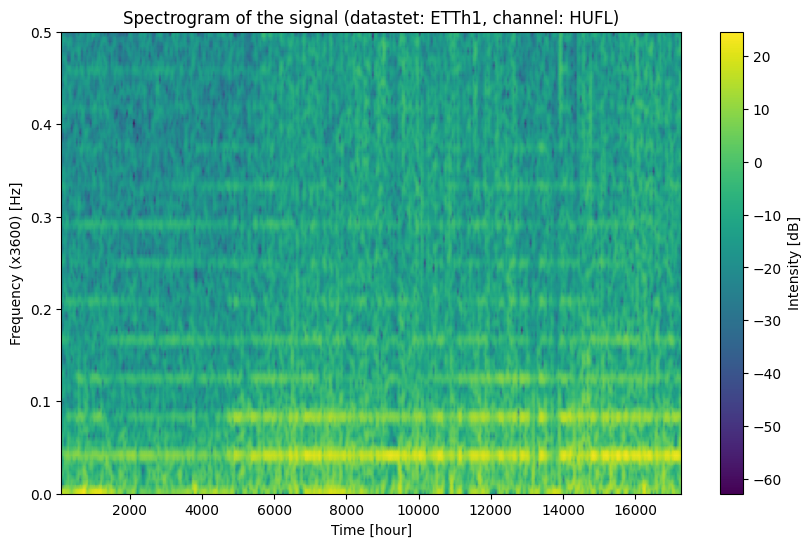

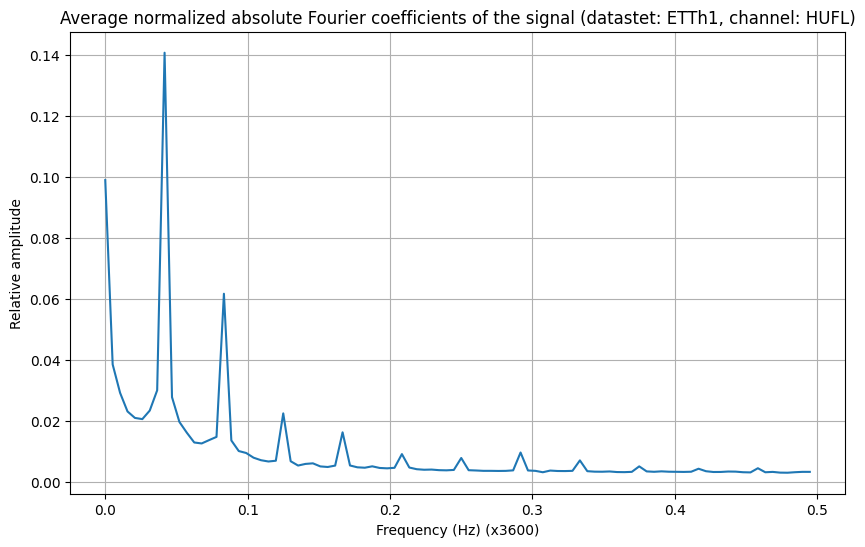

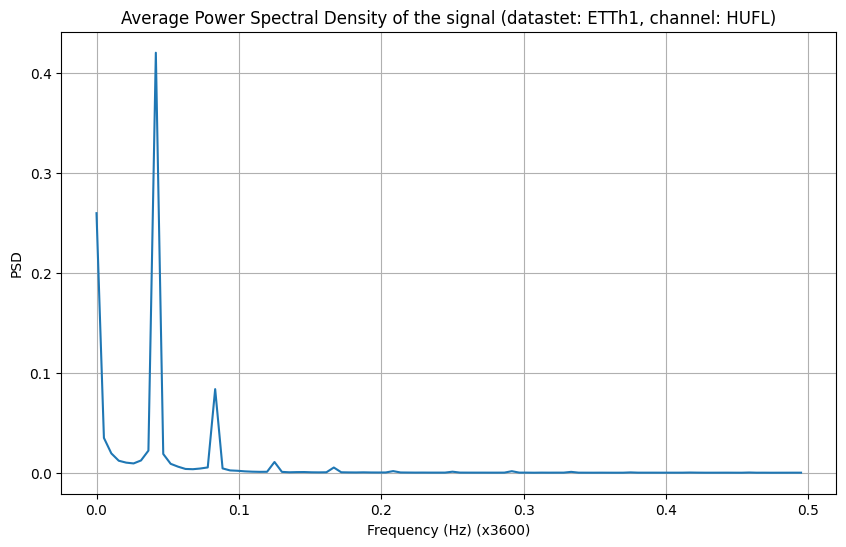

In [17]:
df = pd.read_csv("./dataset/ETT-small/ETTh1.csv")
for channel in ['HUFL']:
    series = df[channel]
    series = (series - np.mean(series)) / np.std(series)
    series = series.to_numpy()
    plot_series(series, start_index=200, num_samples=200, dataset='ETTh1', channel=channel)
    plot_spectrogram(series, N_w=192, N_o=144, dataset='ETTh1', channel=channel)
    plot_average_normalized_absolute_Fourier_coefs(series, dataset='ETTh1', channel=channel)
    plot_average_normalized_PSD(series, dataset='ETTh1', channel=channel)

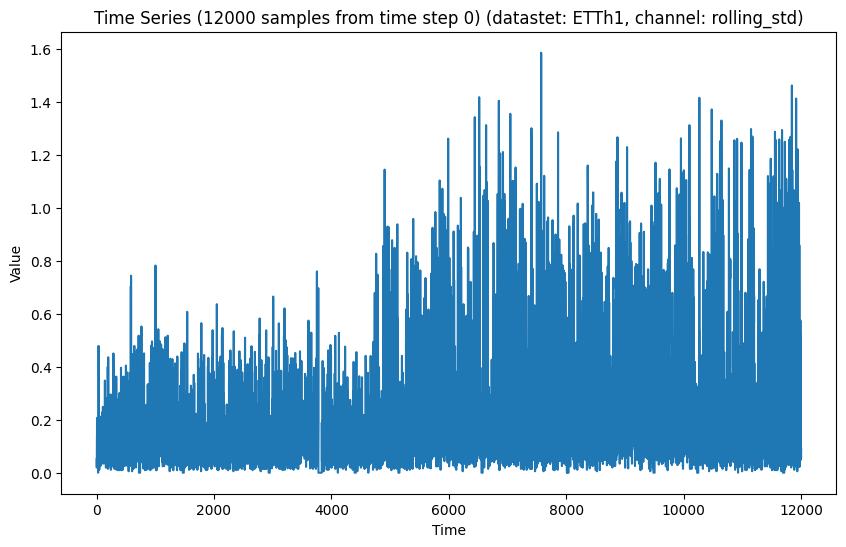

In [8]:
df = pd.read_csv("./dataset/ETT-small/ETTh1.csv")
series = df["HUFL"]
series = (series - np.mean(series)) / np.std(series)
rolling_std = series.rolling(window=3).std()
std_of_rolling_std = np.std(rolling_std.dropna())
series = series.to_numpy()
plot_series(rolling_std.to_numpy(), start_index=0, num_samples=12000, dataset='ETTh1', channel='rolling_std')

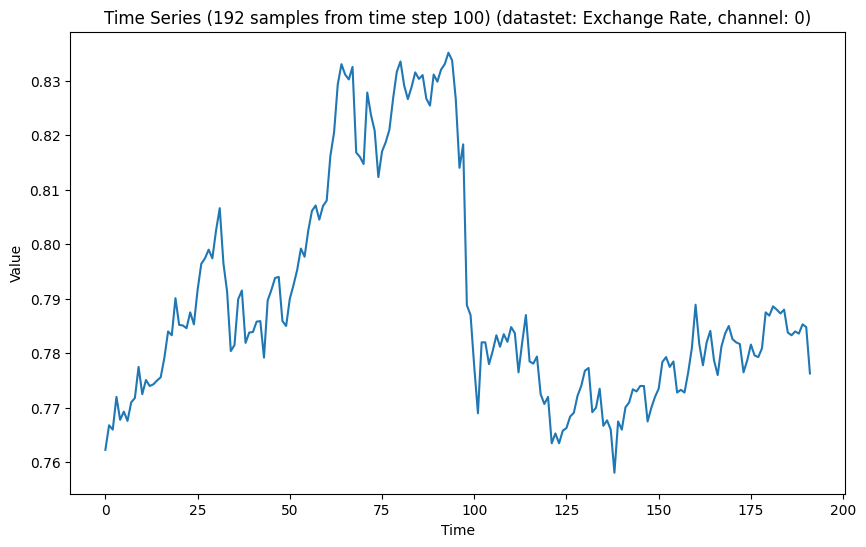

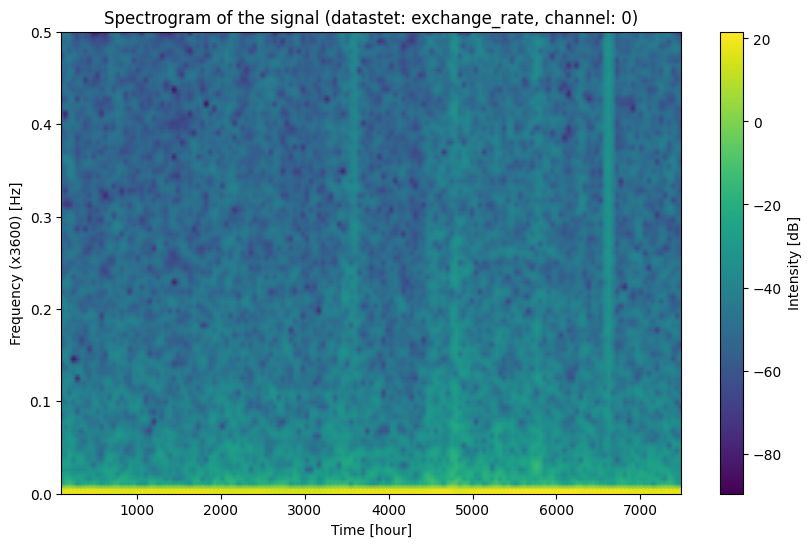

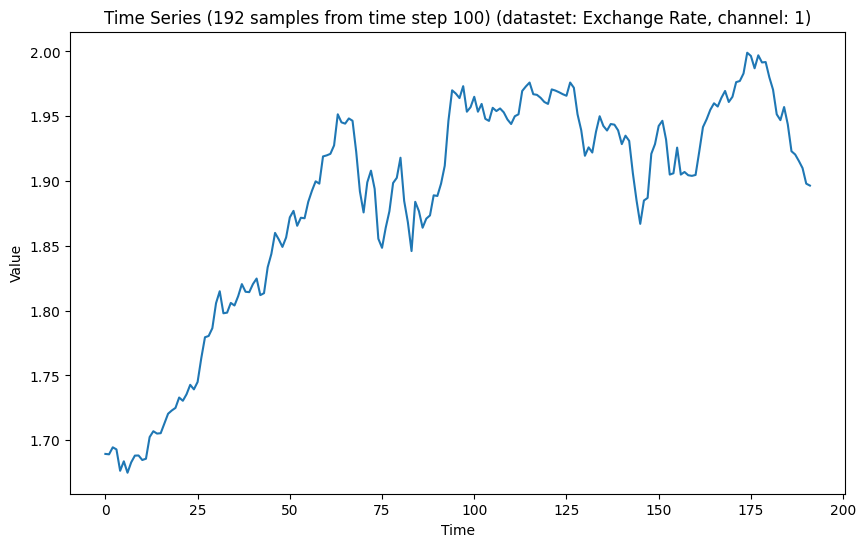

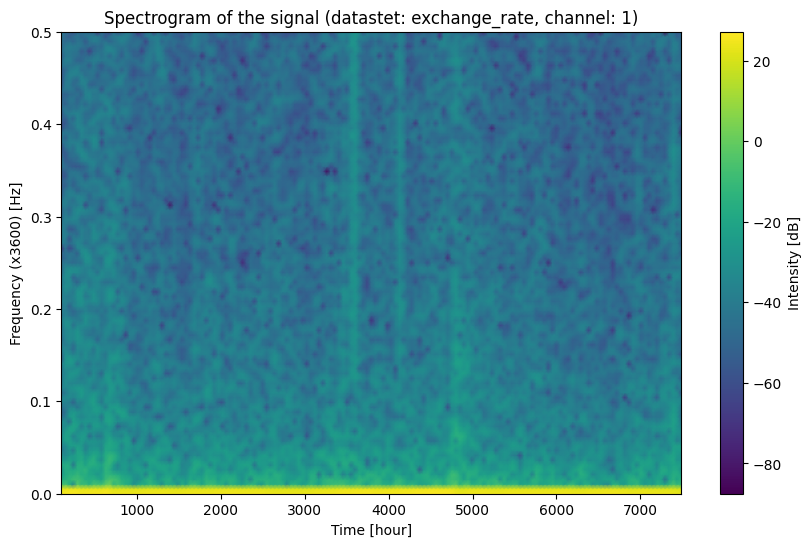

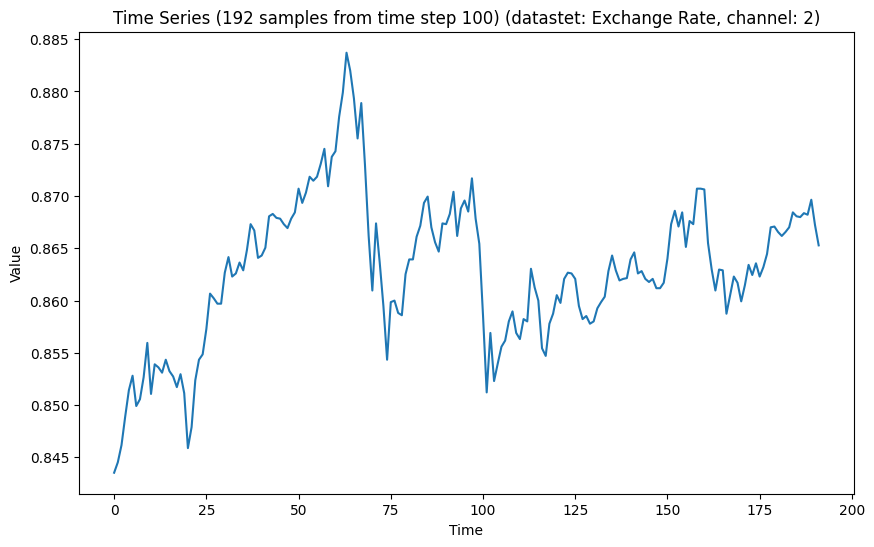

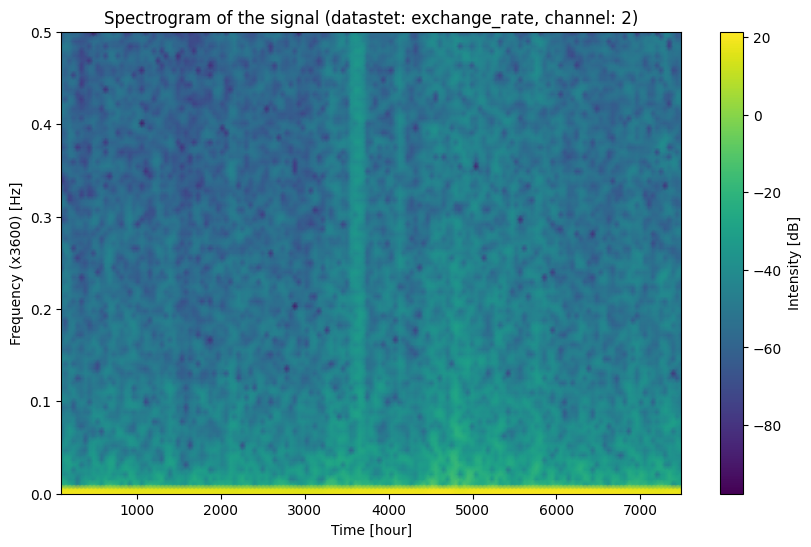

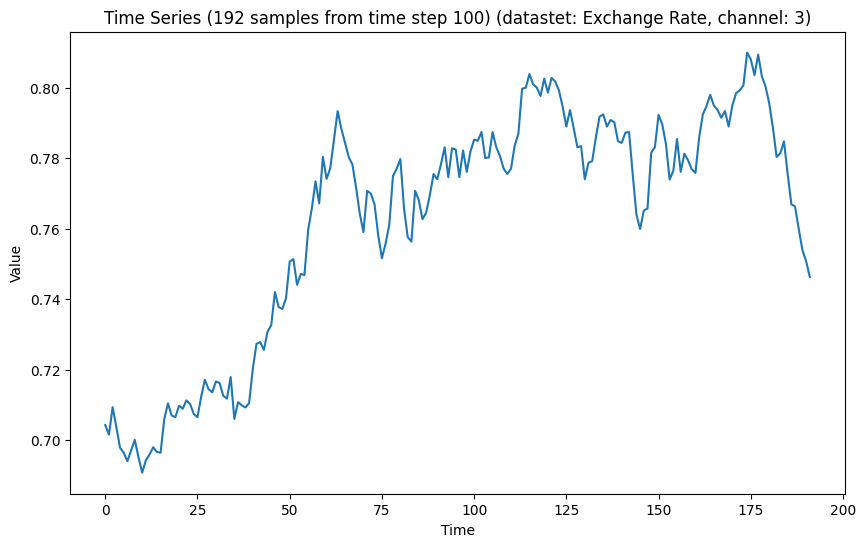

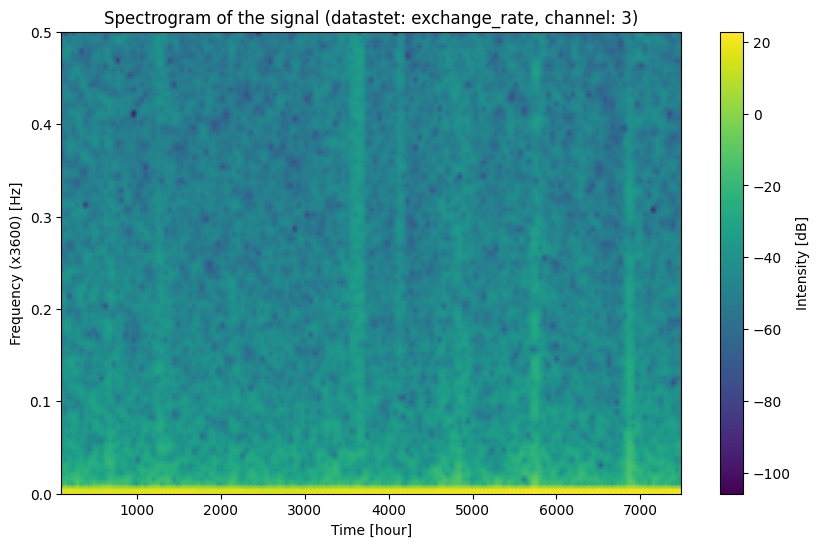

In [9]:
df = pd.read_csv("./dataset/exchange_rate/exchange_rate.csv")
for i in range(0, 4):
    series = df[str(i)]
    series = series.to_numpy()
    plot_series(series, dataset='Exchange Rate', channel=str(i))
    plot_spectrogram(series, N_w=192, N_o=144, dataset='exchange_rate', channel=str(i))

Observation: Exchange is one of the most unpredictable dataset, which is highlighted by the poverty of its spectrograms.